In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde, linregress, t
from scipy.signal import argrelextrema

from sklearn.metrics import r2_score

from ase import units

mpl.rcParams["axes.linewidth"] =  1.5
mpl.rcParams["axes.grid"] = False

mpl.rcParams["axes.labelweight"] = "bold"
mpl.rcParams["axes.spines.left"] = True
mpl.rcParams["axes.spines.bottom"] = True
mpl.rcParams["axes.spines.top"] = True
mpl.rcParams["axes.spines.right"] = True

mpl.rcParams["xtick.major.width"] = 1.5
mpl.rcParams["ytick.major.width"] = 1.5
mpl.rcParams["ytick.minor.visible"] = True
mpl.rcParams["xtick.minor.visible"] = True
mpl.rcParams["xtick.minor.width"] = 1.0
mpl.rcParams["ytick.minor.width"] = 1.0
mpl.rcParams["xtick.minor.size"] =  2.5
mpl.rcParams["ytick.minor.size"] =  2.5
mpl.rcParams["xtick.direction"] =  'in'
mpl.rcParams["ytick.direction"] =  'in'
mpl.rcParams["xtick.major.size"] =  5
mpl.rcParams["ytick.major.size"] =  5

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight'] ='bold'
mpl.rcParams['font.size'] = 12.0
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

%matplotlib inline

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

def moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='same')

def moving_std(data, window_size):
    """Calculates moving standard deviation with padding."""
    windows = np.lib.stride_tricks.sliding_window_view(data, window_size)
    std_dev = np.std(windows, axis=1)
    padding = np.full(window_size - 1, np.nan)
    padded_std = np.concatenate([padding, std_dev])
    return padded_std

def apply_kwargs(ax, x, y, kwargs):
    if kwargs is None:
        ax.plot(x, y)
    else:
        ax.plot(x, y, **kwargs)

def confidence_interval(x, res):
    # Two-sided inverse Students t-distribution
    # p - probability, df - degrees of freedom
    tinv = lambda p, df: abs(t.ppf(p/2, df))
    ts = tinv(0.05, len(x)-2)
    slope_confidence = ts * res.stderr
    intercept_confidence = ts * res.intercept_stderr
    return slope_confidence, intercept_confidence


def linregress_with_ci(x, y):
    res = linregress(x, y)
    slope = res.slope
    intercept = res.intercept
    r2 = res.rvalue**2
    slope_ci, intercept_ci = confidence_interval(x, res)
    return slope, intercept, r2, slope_ci, intercept_ci

def unit_vector(vector):
    return vector / np.linalg.norm(vector) 

def angle_between_vectors(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    value = np.arccos(np.clip(np.dot(v1_u, v2_u), -1, 1))
    if np.isnan(value):
        return -1
    else:
        return value


def label_mosaic_subplot(axs, outside = False):
    for label, ax in axs.items():
    # Use Axes.annotate to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset half-a-fontsize right and half-a-fontsize down
    #   (offset fontsize (+0.5, -0.5)),
    # i.e. just inside the axes.
        if outside:
           ax.annotate(
                label,
                xy=(-0.1, 1.12), xycoords='axes fraction',
                horizontalalignment='center',
                verticalalignment='center',
                #xytext=(-0.5, +0.5), textcoords='offset fontsize',
                #verticalalignment='top', # fontsize='medium', fontfamily='serif',
                #bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
                ) 
        else:
            ax.annotate(
                label,
                xy=(0, 1), xycoords='axes fraction',
                xytext=(+0.5, -0.5), textcoords='offset fontsize',
                 verticalalignment='top', 
                # fontsize='medium',
                #fontfamily='serif',
                #bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
                )

def set_ticks(ax, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 5):
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
    if xlinear: ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(xticks))
    if xmax: ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(xticks))
    if ylinear: ax.yaxis.set_major_locator(mpl.ticker.LinearLocator(yticks))
    if ymax: ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(yticks))



def save_figure(fig, prefix):
    for suffix in ['eps', 'pdf', 'png', 'tiff']:
        fig.savefig(f'{suffix}/{prefix}.{suffix}')


'''
axs["a)"].text(
        0.65, 0.85,
        r'Total Spectra',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs["a)"].transAxes
        )


axs["a)"].text(
        0.65, 0.75,
        r'Si-BEA',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs["a)"].transAxes
        )




axs["b)"].text(
        0.65, 0.85,
        r'Total Spectra',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs["b)"].transAxes
        )


axs["b)"].text(
        0.65, 0.75,
        r'Sn9-BEA',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs["b)"].transAxes
        )



axs["c)"].text(
        0.65, 0.85,
        r'Total Spectra',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs["c)"].transAxes
        )


axs["c)"].text(
        0.65, 0.75,
        r'SnOH9-BEA',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs["c)"].transAxes
        )

'''


'\naxs["a)"].text(\n        0.65, 0.85,\n        r\'Total Spectra\',\n        color= "blue",\n        horizontalalignment=\'center\',\n        verticalalignment=\'center\',\n        transform = axs["a)"].transAxes\n        )\n\n\naxs["a)"].text(\n        0.65, 0.75,\n        r\'Si-BEA\',\n        color= "blue",\n        horizontalalignment=\'center\',\n        verticalalignment=\'center\',\n        transform = axs["a)"].transAxes\n        )\n\n\n\n\naxs["b)"].text(\n        0.65, 0.85,\n        r\'Total Spectra\',\n        color= "blue",\n        horizontalalignment=\'center\',\n        verticalalignment=\'center\',\n        transform = axs["b)"].transAxes\n        )\n\n\naxs["b)"].text(\n        0.65, 0.75,\n        r\'Sn9-BEA\',\n        color= "blue",\n        horizontalalignment=\'center\',\n        verticalalignment=\'center\',\n        transform = axs["b)"].transAxes\n        )\n\n\n\naxs["c)"].text(\n        0.65, 0.85,\n        r\'Total Spectra\',\n        color= "blue",\n     

In [2]:

linestyles = ["solid", "dashed", "solid", "dashed", "solid", "dashed"]
linestyles = ["solid", 
              (0, (5, 1)), 
              (0, (5, 5)), 
              (0, (3, 1, 1, 1)), 
              (0, (3, 5, 1, 5)),
              ]


from scipy.signal import savgol_filter

#df = pd.read_csv(filename)
#df['Sv_tot (cm)'] = savgol_filter(df['Sv_tot (cm)'], filter_window, 3)
#axs.plot(df['Freq (1/cm)'], df['Sv_tot (cm)'], label = label, color = color, linestyle = linestyle)

def plot_2pt(axs, filename, colors, decomposed = True, linestyle = "solid", label = None, color = "blue", normalize = None, filter = False, filter_window=1000, verbose = False):
    
    if decomposed:
        df = pd.read_csv(filename)
        if normalize is not None:
            df['Sv_tot (cm)'] /= normalize
            df['Sv_trn (cm)'] /= normalize
            df['Sv_rot (cm)'] /= normalize
            df['Sv_vib (cm)'] /= normalize
            df['Sv_trn_s (cm)'] /= normalize
            df['Sv_trn_g (cm)'] /= normalize
            df['Sv_rot_s (cm)'] /= normalize
            df['Sv_rot_g (cm)'] /= normalize


        if filter:
            
            df['Sv_tot (cm)'] = savgol_filter(df['Sv_tot (cm)'], filter_window, 3)
            df['Sv_trn (cm)'] = savgol_filter(df['Sv_trn (cm)'], filter_window, 3)
            df['Sv_rot (cm)'] = savgol_filter(df['Sv_rot (cm)'], filter_window, 3)
            df['Sv_vib (cm)'] = savgol_filter(df['Sv_vib (cm)'], filter_window, 3)
            df['Sv_trn_s (cm)'] = savgol_filter(df['Sv_trn_s (cm)'], filter_window, 3)
            df['Sv_trn_g (cm)'] = savgol_filter(df['Sv_trn_g (cm)'], filter_window, 3)
            df['Sv_rot_s (cm)'] = savgol_filter(df['Sv_rot_s (cm)'], filter_window, 3)
            df['Sv_rot_g (cm)'] = savgol_filter(df['Sv_rot_g (cm)'], filter_window, 3)

        ax = axs[0]
        ax.plot(df['Freq (1/cm)'], df['Sv_tot (cm)'], color = colors[0], label = "Total", linestyle = "solid")
        ax.plot(df['Freq (1/cm)'], df['Sv_trn (cm)'], color = colors[1],  label = "Trn", linestyle = "dashed")
        ax.plot(df['Freq (1/cm)'], df['Sv_rot (cm)'], color = colors[2],  label = "Rot", linestyle = "dashdot")
        ax.plot(df['Freq (1/cm)'], df['Sv_vib (cm)'], color = colors[3],  label = "Vib", linestyle = "dotted")


        #ax.set_xlim((0, 1000))
        # #ax.set_ylim((0, 12))
        ax.set_xlabel(r"$\omega$ (1/cm)")
        ax.set_ylabel(r"VDoS($\omega$) (cm)")
        #ax.legend()

        ax = axs[1]
        ax.plot(df['Freq (1/cm)'], df['Sv_trn (cm)'], color = colors[1], linestyle = "dashed")
        ax.plot(df['Freq (1/cm)'], df['Sv_trn_s (cm)'],  color = colors[4], label = "Trn(s)", linestyle = "dotted")
        ax.plot(df['Freq (1/cm)'], df['Sv_trn_g (cm)'], color = colors[5], label = "Trn(g)", linestyle = "dashdot")

        #ax.set_xlim((0, 500))
        #ax.set_ylim((0, 12))  
        ax.set_xlabel(r"$\omega$ (1/cm)")
        #ax.set_ylabel(r"S($\nu$) (cm)")

        #ax.legend()

        ax = axs[2]
        ax.plot(df['Freq (1/cm)'], df['Sv_rot (cm)'],  color = colors[2], linestyle = "dashdot")
        ax.plot(df['Freq (1/cm)'], df['Sv_rot_s (cm)'], color = colors[6], label = "Rot(s)", linestyle="dotted")
        ax.plot(df['Freq (1/cm)'], df['Sv_rot_g (cm)'], color = colors[7],label = "Rot(g)",linestyle = "dashed" )

        #ax.set_xlim((0, 1000))
        #ax.set_ylim((0, 4))
        ax.set_xlabel(r"$\omega$ (1/cm)")
        #ax.set_ylabel(r"S($\nu$) (cm)")

        #ax.legend()

    else:
        df = pd.read_csv(filename)
        if normalize is not None:
            df['Sv_tot (cm)'] /= normalize

        if filter:          
            df['Sv_tot (cm)'] = savgol_filter(df['Sv_tot (cm)'], filter_window, 3)



            
        axs.plot(df['Freq (1/cm)'], df['Sv_tot (cm)'], label = label, color = color, linestyle = linestyle)


        #ax.set_xlim((0, 1000))
        # #ax.set_ylim((0, 12))
        #axs.set_xlabel(r"$\nu$ (1/cm)")
        #axs.set_ylabel(r"S($\nu$) (cm)")
        return df


def plot_2pt_temperature_effect(axs, temps, filename_prefix, filename_suffix, filter = False, filter_window=1000, linestyles = ["solid", "dashed", "dashdot", "dotted"]):
    for i, temp in enumerate(temps):
        df = pd.read_csv(f"{filename_prefix}/{temp}/{filename_suffix}/sv.csv")
        
        ax = axs[0]

        if filter:
            df['Sv_tot (cm)'] = savgol_filter(df['Sv_tot (cm)'], filter_window, 3)
            df['Sv_trn (cm)'] = savgol_filter(df['Sv_trn (cm)'], filter_window, 3)
            df['Sv_rot (cm)'] = savgol_filter(df['Sv_rot (cm)'], filter_window, 3)
            df['Sv_vib (cm)'] = savgol_filter(df['Sv_vib (cm)'], filter_window, 3)


        ax.plot(df['Freq (1/cm)'], df['Sv_vib (cm)'], label = f"{temp} K", linestyle = linestyles[i])
        ax.set_xlabel(r"$\omega$ (1/cm)")
        ax.set_ylabel(r"VDoS($\omega$) (cm)")
        ax = axs[1]
        ax.plot(df['Freq (1/cm)'], df['Sv_trn (cm)'], linestyle = linestyles[i])
        ax.set_xlabel(r"$\omega$ (1/cm)")
        ax = axs[2]
        ax.plot(df['Freq (1/cm)'], df['Sv_rot (cm)'], linestyle = linestyles[i])  
        ax.set_xlabel(r"$\omega$ (1/cm)")



def plot_2pt_zeolite_effect(axs, zeos, filename_prefix, filename_suffix, labels, filter = False, filter_window=1000, linestyles = ["solid", "dashed", "dashdot", "dotted"]):
    i = 0
    for zeo in zeos:

        '''
        if zeo == "pureSi":
            label = "Si-BEA"

        elif zeo == "t9":
            label = "Sn9-BEA"

        elif zeo == "st9":
            label = "SnOH9-BEA"'
        '''

        df = pd.read_csv(f"{filename_prefix}/{zeo}/{filename_suffix}/sv.csv")

        if filter:
            df['Sv_tot (cm)'] = savgol_filter(df['Sv_tot (cm)'], filter_window, 3)
            df['Sv_trn (cm)'] = savgol_filter(df['Sv_trn (cm)'], filter_window, 3)
            df['Sv_rot (cm)'] = savgol_filter(df['Sv_rot (cm)'], filter_window, 3)
            df['Sv_vib (cm)'] = savgol_filter(df['Sv_vib (cm)'], filter_window, 3)
        ax = axs[0]

        ax.plot(df['Freq (1/cm)'], df['Sv_vib (cm)'], label = labels[i], linestyle = linestyles[i])
        ax.set_xlabel(r"$\omega$ (1/cm)")
        ax.set_ylabel(r"VDoS($\omega$) (cm)")
        ax = axs[1]
        ax.plot(df['Freq (1/cm)'], df['Sv_trn (cm)'], linestyle = linestyles[i])
        ax.set_xlabel(r"$\omega$ (1/cm)")
        ax = axs[2]
        ax.plot(df['Freq (1/cm)'], df['Sv_rot (cm)'], linestyle = linestyles[i])  
        ax.set_xlabel(r"$\omega$ (1/cm)")
        i += 1




    

        


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


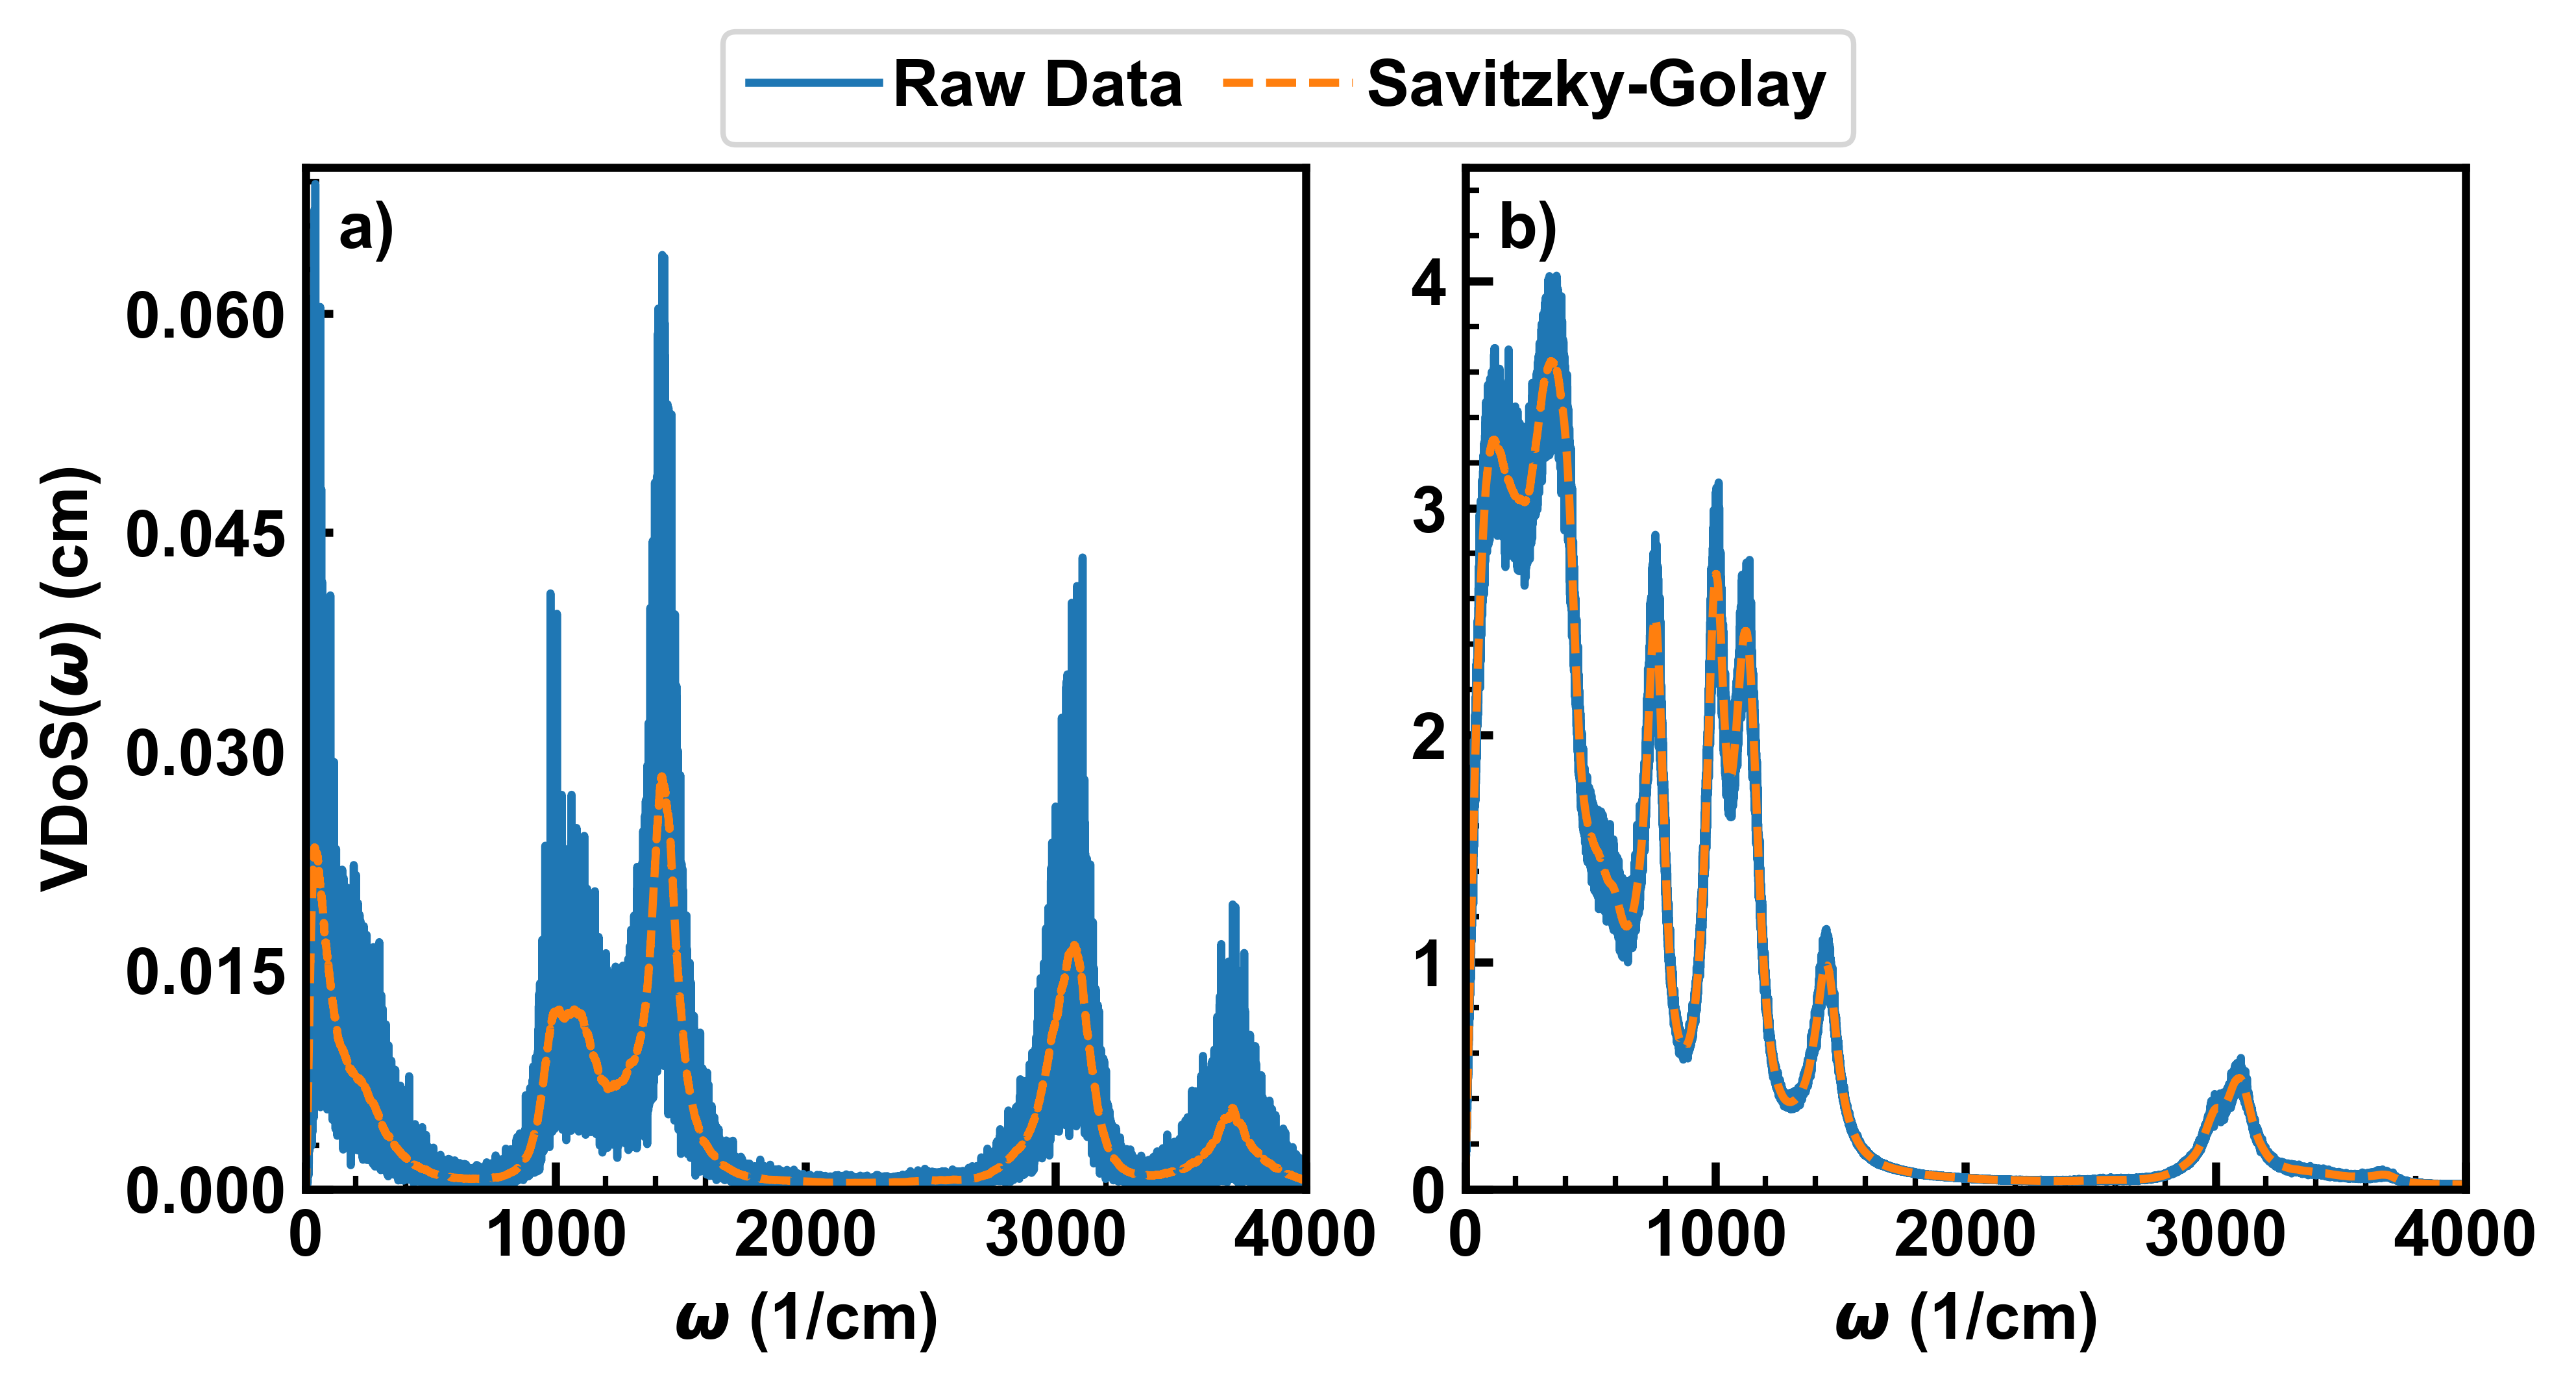

In [3]:
fig, axs = plt.subplot_mosaic([["a)", "b)"]], figsize=(6.5,3.5), sharey = False, dpi=600, layout='constrained')

plot_2pt(axs["a)"] , "../solvents/meoh-373-1atm/vdos/sv.csv", colors, decomposed=False, label = "Raw Data", color = colors[0], normalize = 1, filter = False, filter_window=100, linestyle="solid")
plot_2pt(axs["a)"] , "../solvents/meoh-373-1atm/vdos/sv.csv", colors, decomposed=False, label = "Savitzky-Golay", color = colors[1], normalize = 1, filter = True, filter_window=1000, linestyle="dashed")

plot_2pt(axs["b)"] , "../meoh-9/t9/373/vdos/all/sv.csv", colors, decomposed=False, color = colors[0], normalize = 1, filter = False, filter_window=100, linestyle="solid")
plot_2pt(axs["b)"] , "../meoh-9/t9/373/vdos/all/sv.csv", colors, decomposed=False, color = colors[1], normalize = 1, filter = True, filter_window=1000, linestyle="dashed")

fig.legend(loc = "outside upper center", ncols = 5, columnspacing = 0.6, handletextpad=0.2)
#axs["a)"].legend()

axs["a)"].set_ylabel(r"VDoS($\omega$) (cm)")
axs['a)'].set_ylim(0.0, 0.07)
axs['b)'].set_ylim(0.0, 4.5)

for key, ax in axs.items():
    
    ax.set_xlim(0, 4000)
    #ax.set_xlabel(r"$\nu$ (1/cm)")
    set_ticks(ax, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 4)

axs["a)"].set_xlabel(r"$\omega$ (1/cm)")
axs["b)"].set_xlabel(r"$\omega$ (1/cm)")
label_mosaic_subplot(axs)

save_figure(fig, "filter-comparison")
pass



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


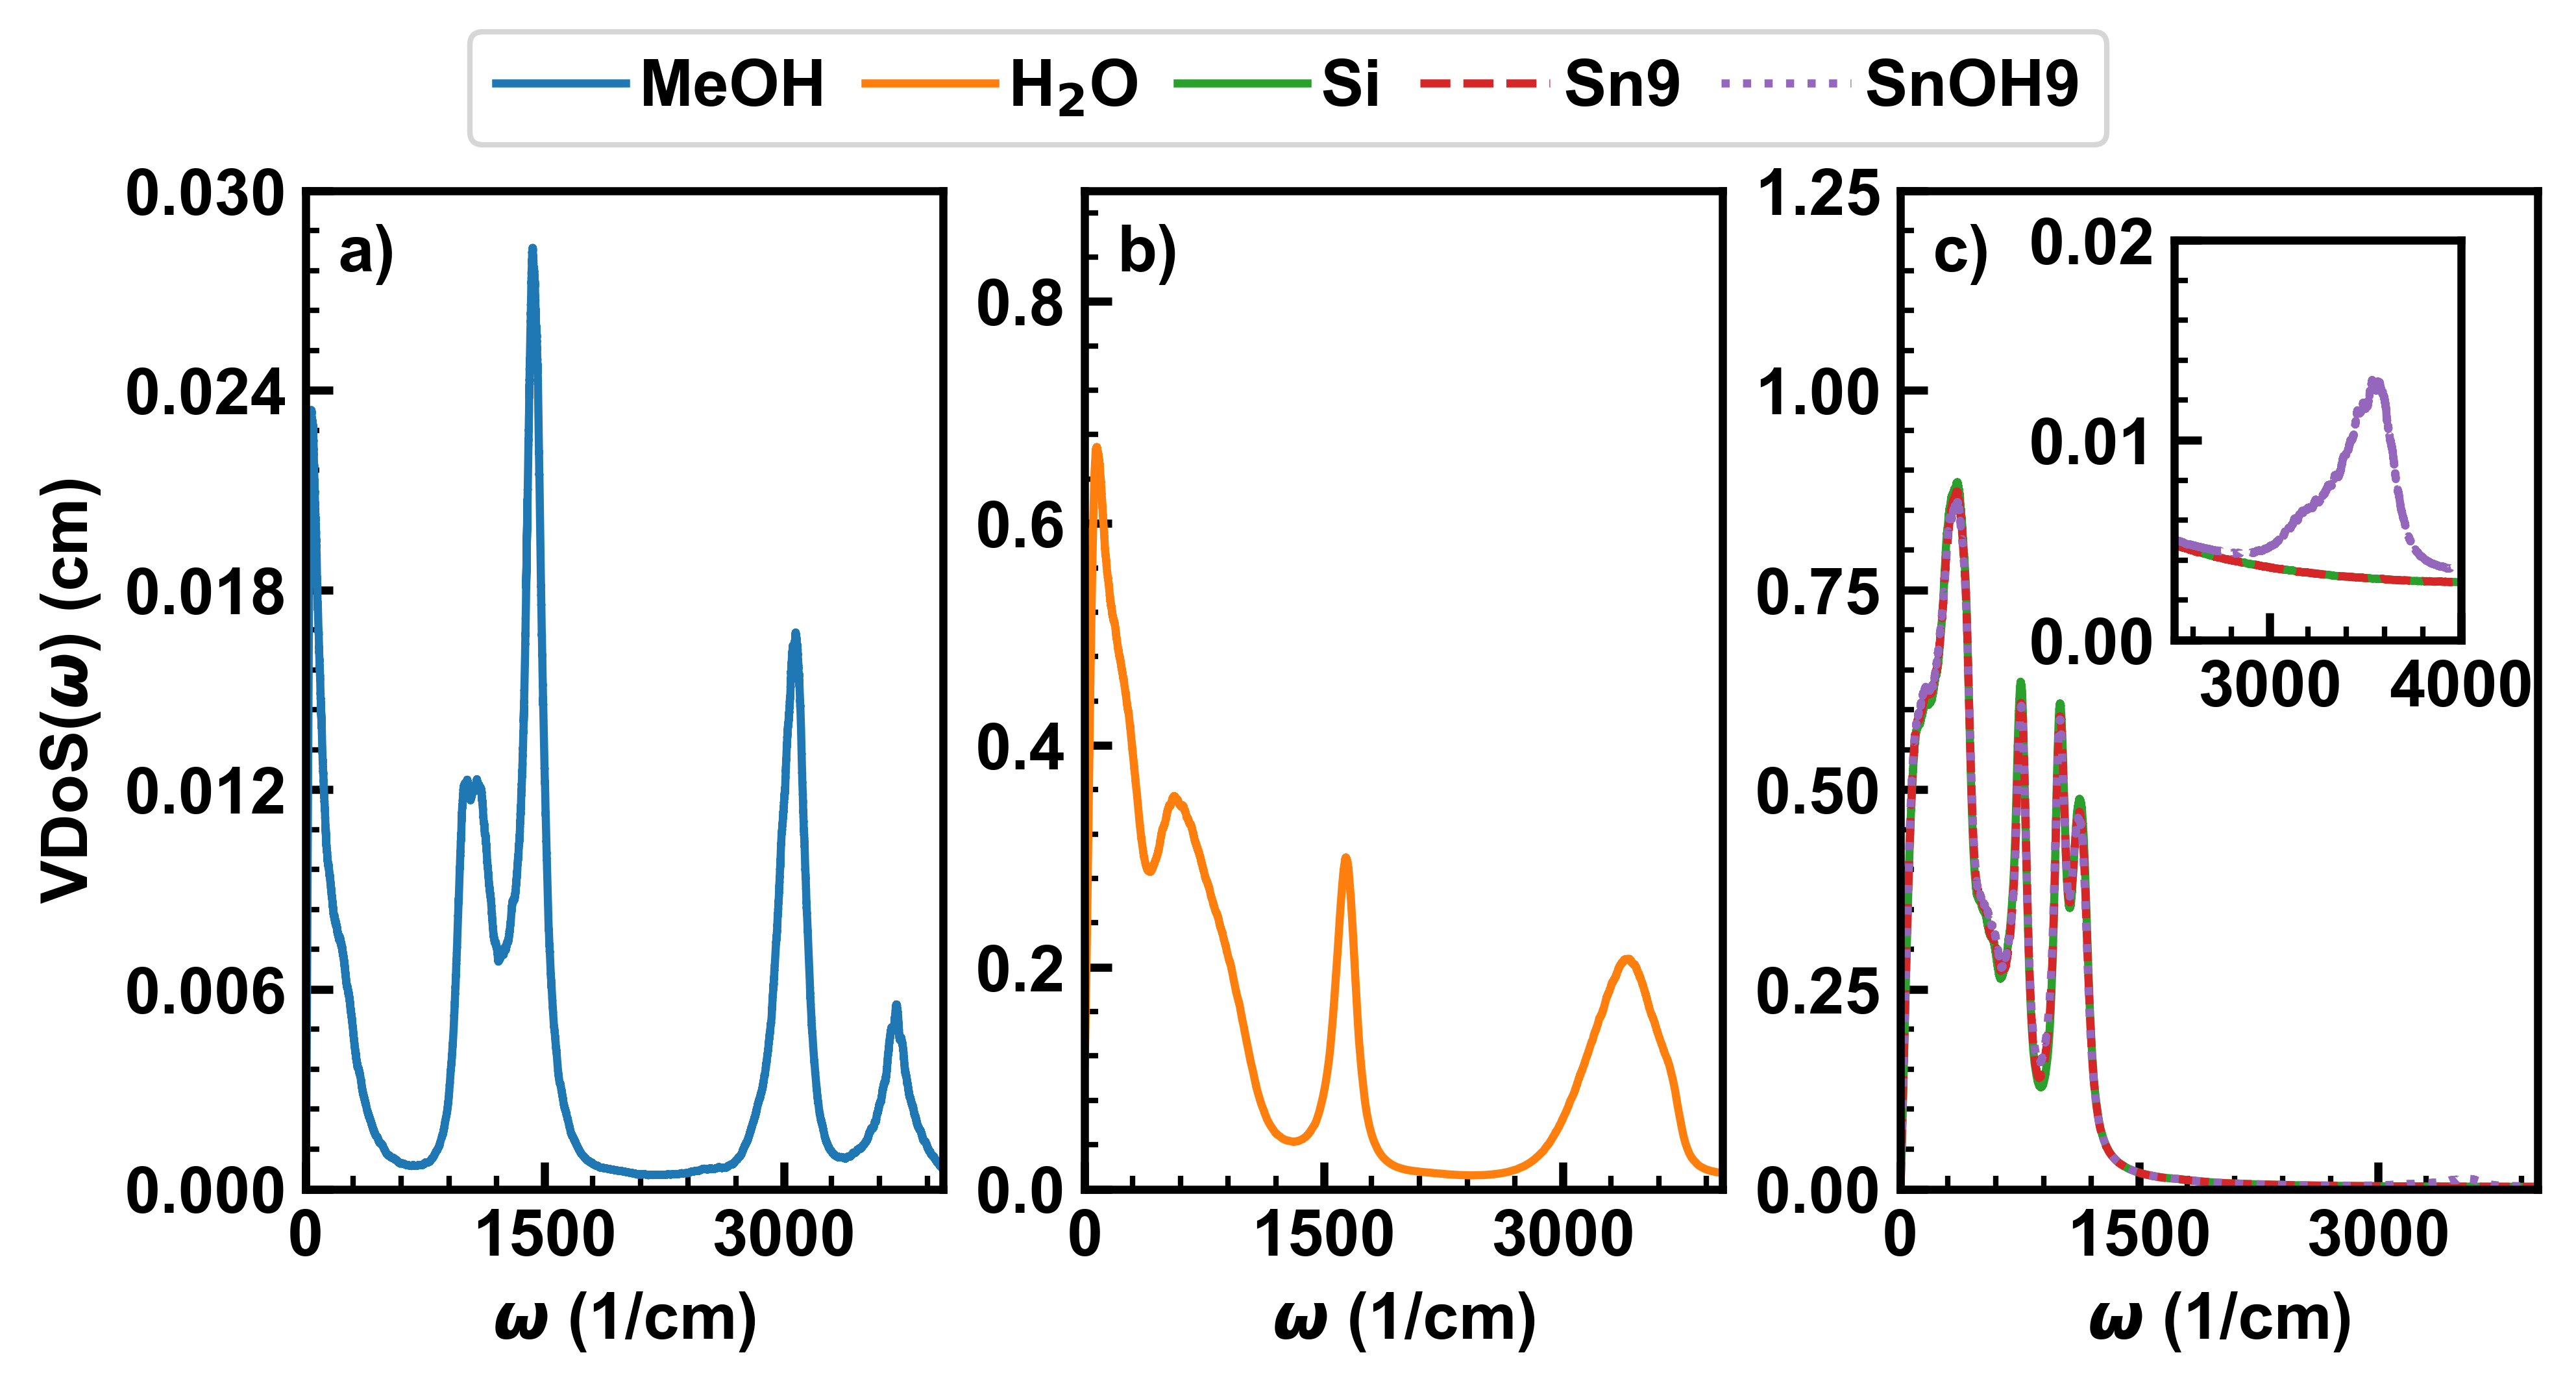

In [4]:
fig, axs = plt.subplot_mosaic([["a)", "b)", "c)"]], figsize=(6.5,3.5), sharey = False, dpi=600, layout='constrained')



plot_2pt(axs["a)"] , "../solvents/meoh-373-1atm/vdos/sv.csv", colors, decomposed=False, label = "MeOH", color = colors[0], normalize = 1, filter = True)

plot_2pt(axs["b)"] , "../solvents/wat-373-1atm/vdos/sv.csv", colors, decomposed=False, label = "H$_2$O", color = colors[1], normalize = 1, filter = True)

plot_2pt(axs["c)"] , "../zeolites/pureSi/vdos/sv.csv", colors, decomposed=False, label = "Si", color = colors[2], normalize = 1, filter = True, linestyle="solid")
plot_2pt(axs["c)"] , "../zeolites/t9/vdos/sv.csv", colors, decomposed=False, label = "Sn9", color = colors[3], normalize = 1, filter = True, linestyle="dashed")
plot_2pt(axs["c)"] , "../zeolites/st9/vdos/sv.csv", colors, decomposed=False, label = "SnOH9", color = colors[4], normalize = 1, filter = True, linestyle="dotted")


fig.legend(loc = "outside upper center", ncols = 5, columnspacing = 0.6, handletextpad=0.2)

axs["a)"].set_ylabel(r"VDoS($\omega$) (cm)")
label_mosaic_subplot(axs)

axs["a)"].set_ylim((0,0.03))
axs["b)"].set_ylim((0,0.9))
axs["c)"].set_ylim((0,1.25))

for key, ax in axs.items():
    #ax.set_ylim(0.0, 6.0)
    ax.set_xlim(0, 4000)
    ax.set_xlabel(r"$\omega$ (1/cm)")
    set_ticks(ax, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 3)




axins = axs["c)"].inset_axes([0.43, 0.55, 0.45, 0.4])
plot_2pt(axins , "../zeolites/pureSi/vdos/sv.csv", colors, decomposed=False, color = colors[2], filter = True, linestyle="solid")
plot_2pt(axins , "../zeolites/t9/vdos/sv.csv", colors, decomposed=False,  color = colors[3], filter = True, linestyle="dashed")
plot_2pt(axins , "../zeolites/st9/vdos/sv.csv", colors, decomposed=False, color = colors[4], filter = True, linestyle="dashdot")
axins.set_xlim(2500, 4000)
axins.set_ylim(0.0, 0.02)
#set_ticks(axins, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 4, xticks = 3)

save_figure(fig, "pure-components_vdos")
pass

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


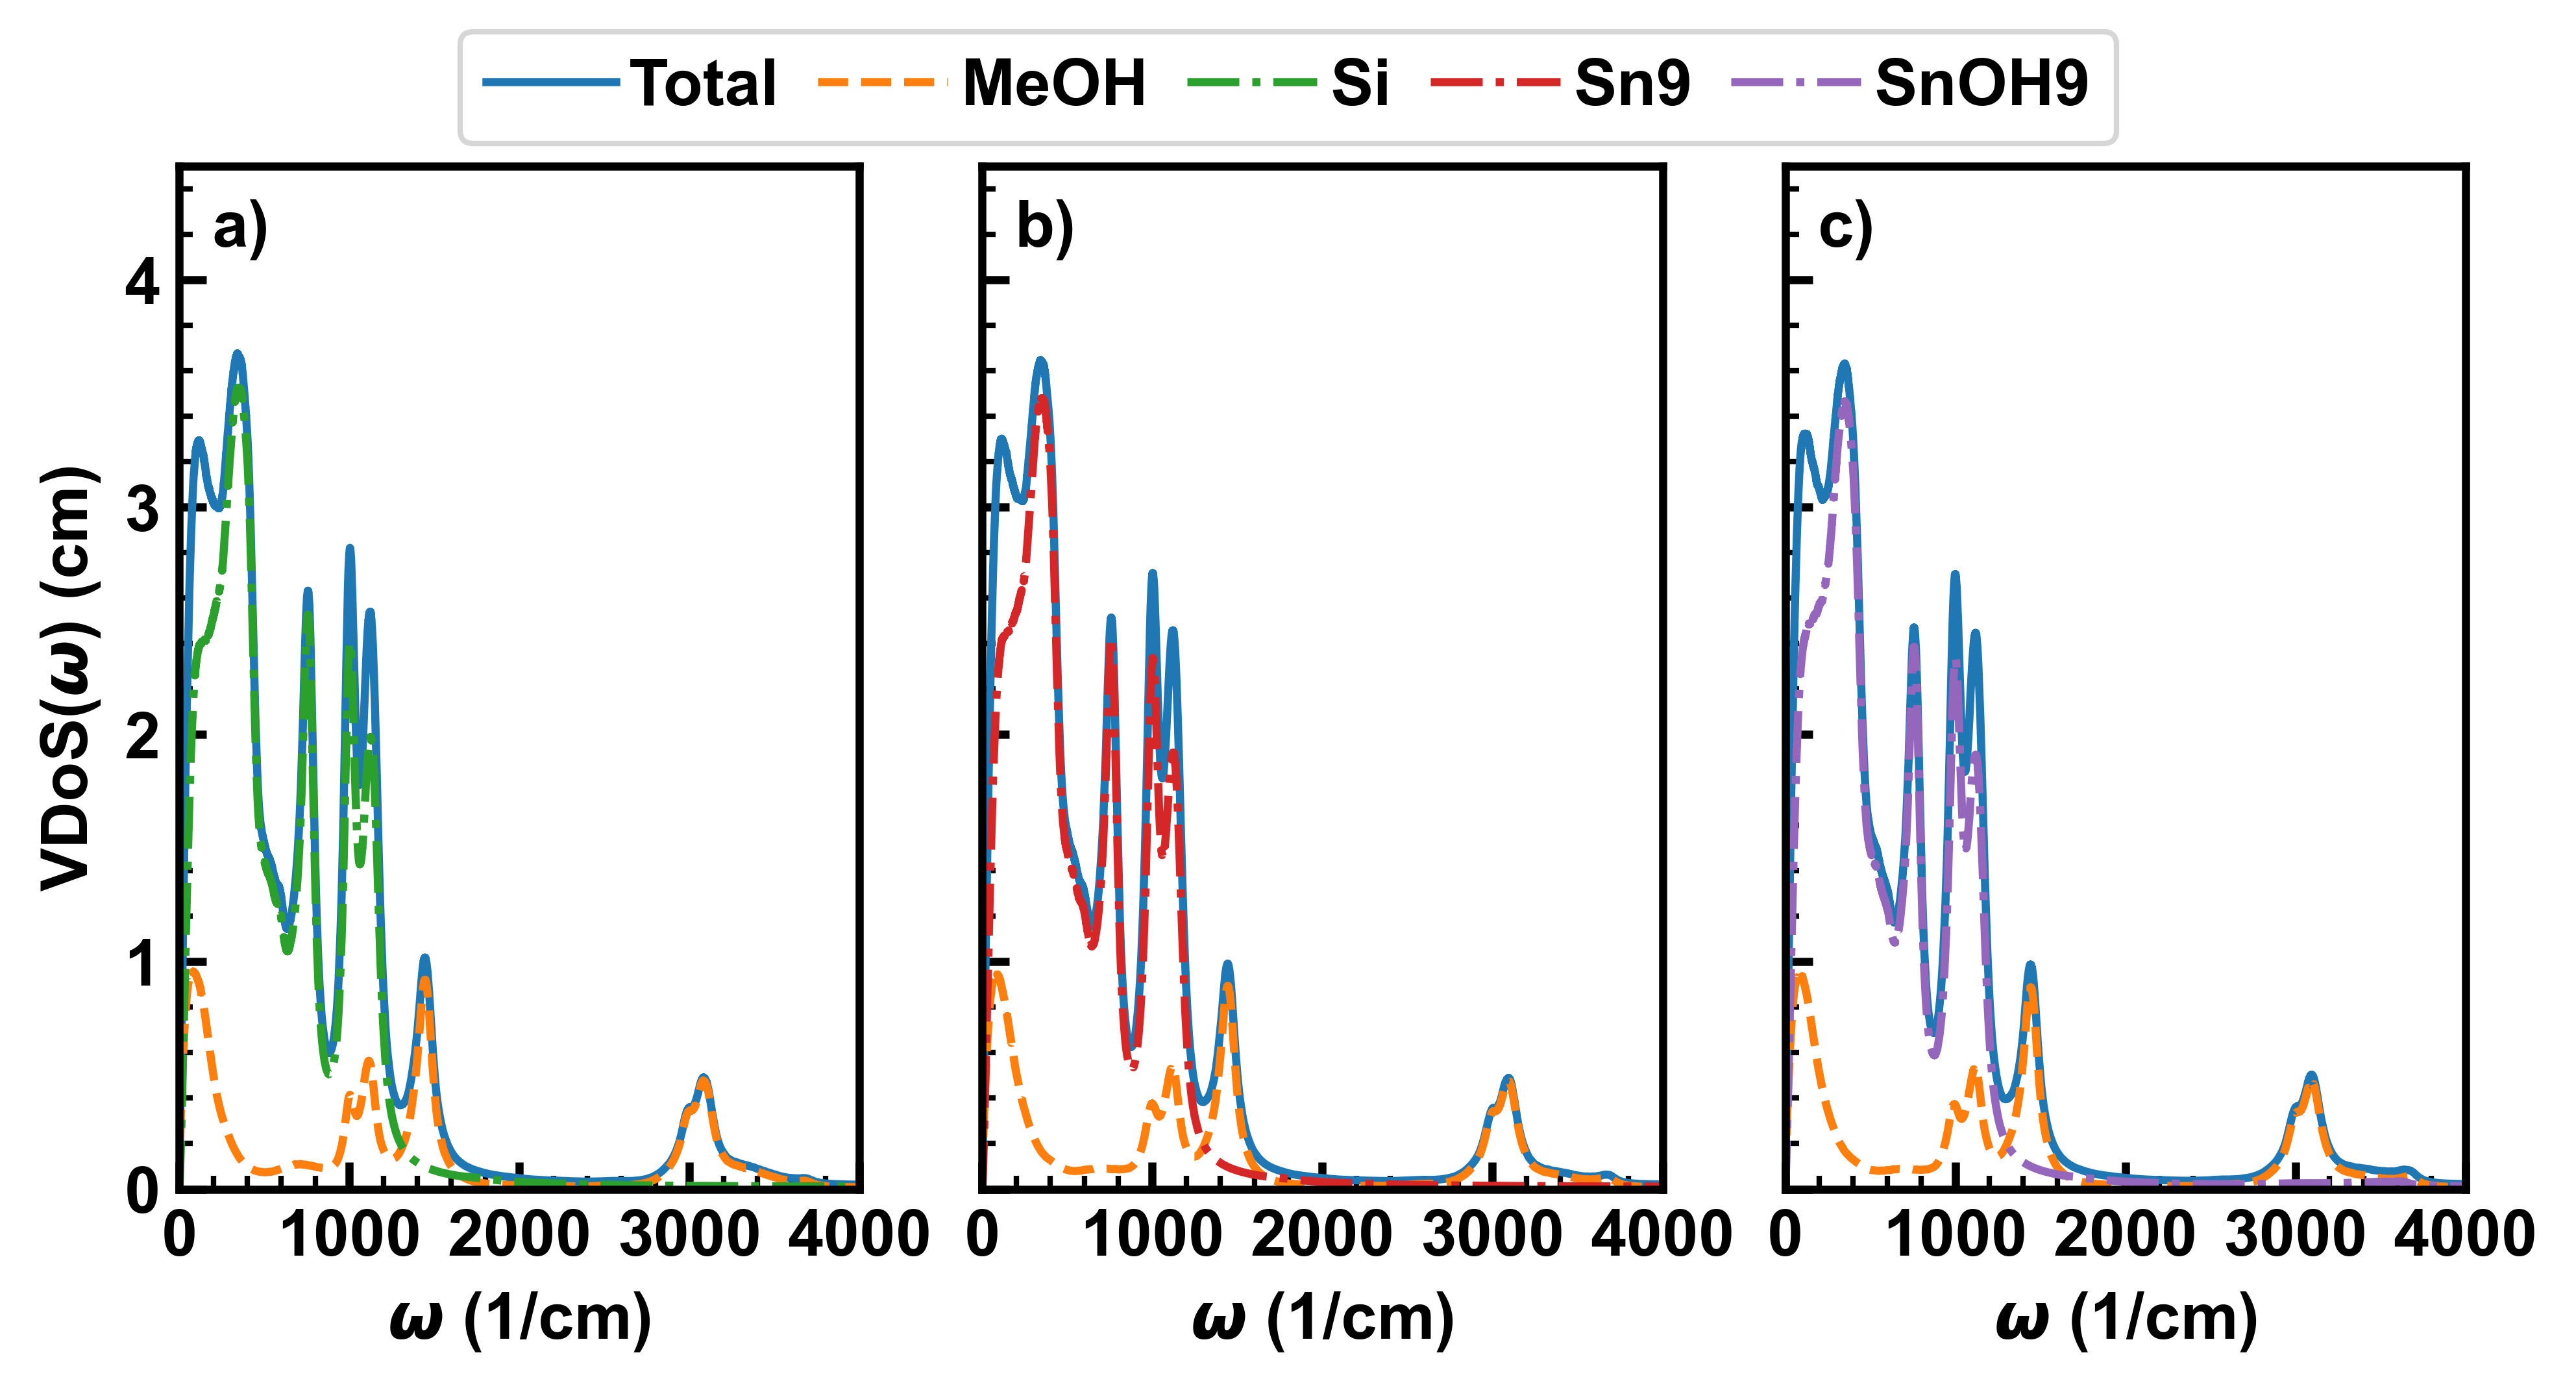

In [5]:
fig, axs = plt.subplot_mosaic([["a)", "b)", "c)"]], figsize=(6.5,3.5), sharey = True, dpi=600, layout='constrained')


plot_2pt(axs["a)"] , "../meoh-9/pureSi/373/vdos/all/sv.csv", colors, decomposed=False, label = "Total", color = colors[0], filter = True, linestyle="solid")
plot_2pt(axs["a)"] , "../meoh-9/pureSi/373/vdos/solvent_all/sv.csv", colors, decomposed=False, label = "MeOH", color = colors[1], filter = True , linestyle="dashed")
plot_2pt(axs["a)"] , "../meoh-9/pureSi/373/vdos/zeolite/sv.csv", colors, decomposed=False, label = "Si", color = colors[2], filter = True, linestyle="dashdot")

plot_2pt(axs["b)"] , "../meoh-9/t9/373/vdos/all/sv.csv", colors, decomposed=False, label = None, color = colors[0], filter = True, linestyle="solid")
plot_2pt(axs["b)"] , "../meoh-9/t9/373/vdos/solvent_all/sv.csv", colors, decomposed=False, label = None, color = colors[1], filter = True, linestyle="dashed")
plot_2pt(axs["b)"] , "../meoh-9/t9/373/vdos/zeolite/sv.csv", colors, decomposed=False, label = "Sn9", color = colors[3], filter = True, linestyle="dashdot")

plot_2pt(axs["c)"] , "../meoh-9/st9/373/vdos/all/sv.csv", colors, decomposed=False, label = None, color = colors[0], filter = True, linestyle="solid")
plot_2pt(axs["c)"] , "../meoh-9/st9/373/vdos/solvent_all/sv.csv", colors, decomposed=False, label = None, color = colors[1], filter = True, linestyle="dashed")
plot_2pt(axs["c)"] , "../meoh-9/st9/373/vdos/zeolite/sv.csv", colors, decomposed=False, label = "SnOH9", color = colors[4], filter = True, linestyle="dashdot")


fig.legend(loc = "outside upper center", ncols = 8, columnspacing = 0.6, handletextpad=0.2)


for key, ax in axs.items():
    ax.set_xlim(0, 4000)
    ax.set_xlabel(r"$\omega$ (1/cm)")
    set_ticks(ax, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 4)

axs["a)"].set_ylim(0.0, 4.5)
axs["a)"].set_ylabel(r"VDoS($\omega$) (cm)")

label_mosaic_subplot(axs)

"""
axs["c)"].text(
        0.65, 0.75,
        r'Total Spectra',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs["c)"].transAxes
        )


axs["c)"].text(
        0.65, 0.65,
        r'$T$ = 373 K',
        color= "blue",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs["c)"].transAxes
        )
"""


save_figure(fig, "meoh-zeolite-373_comparison-vdos")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


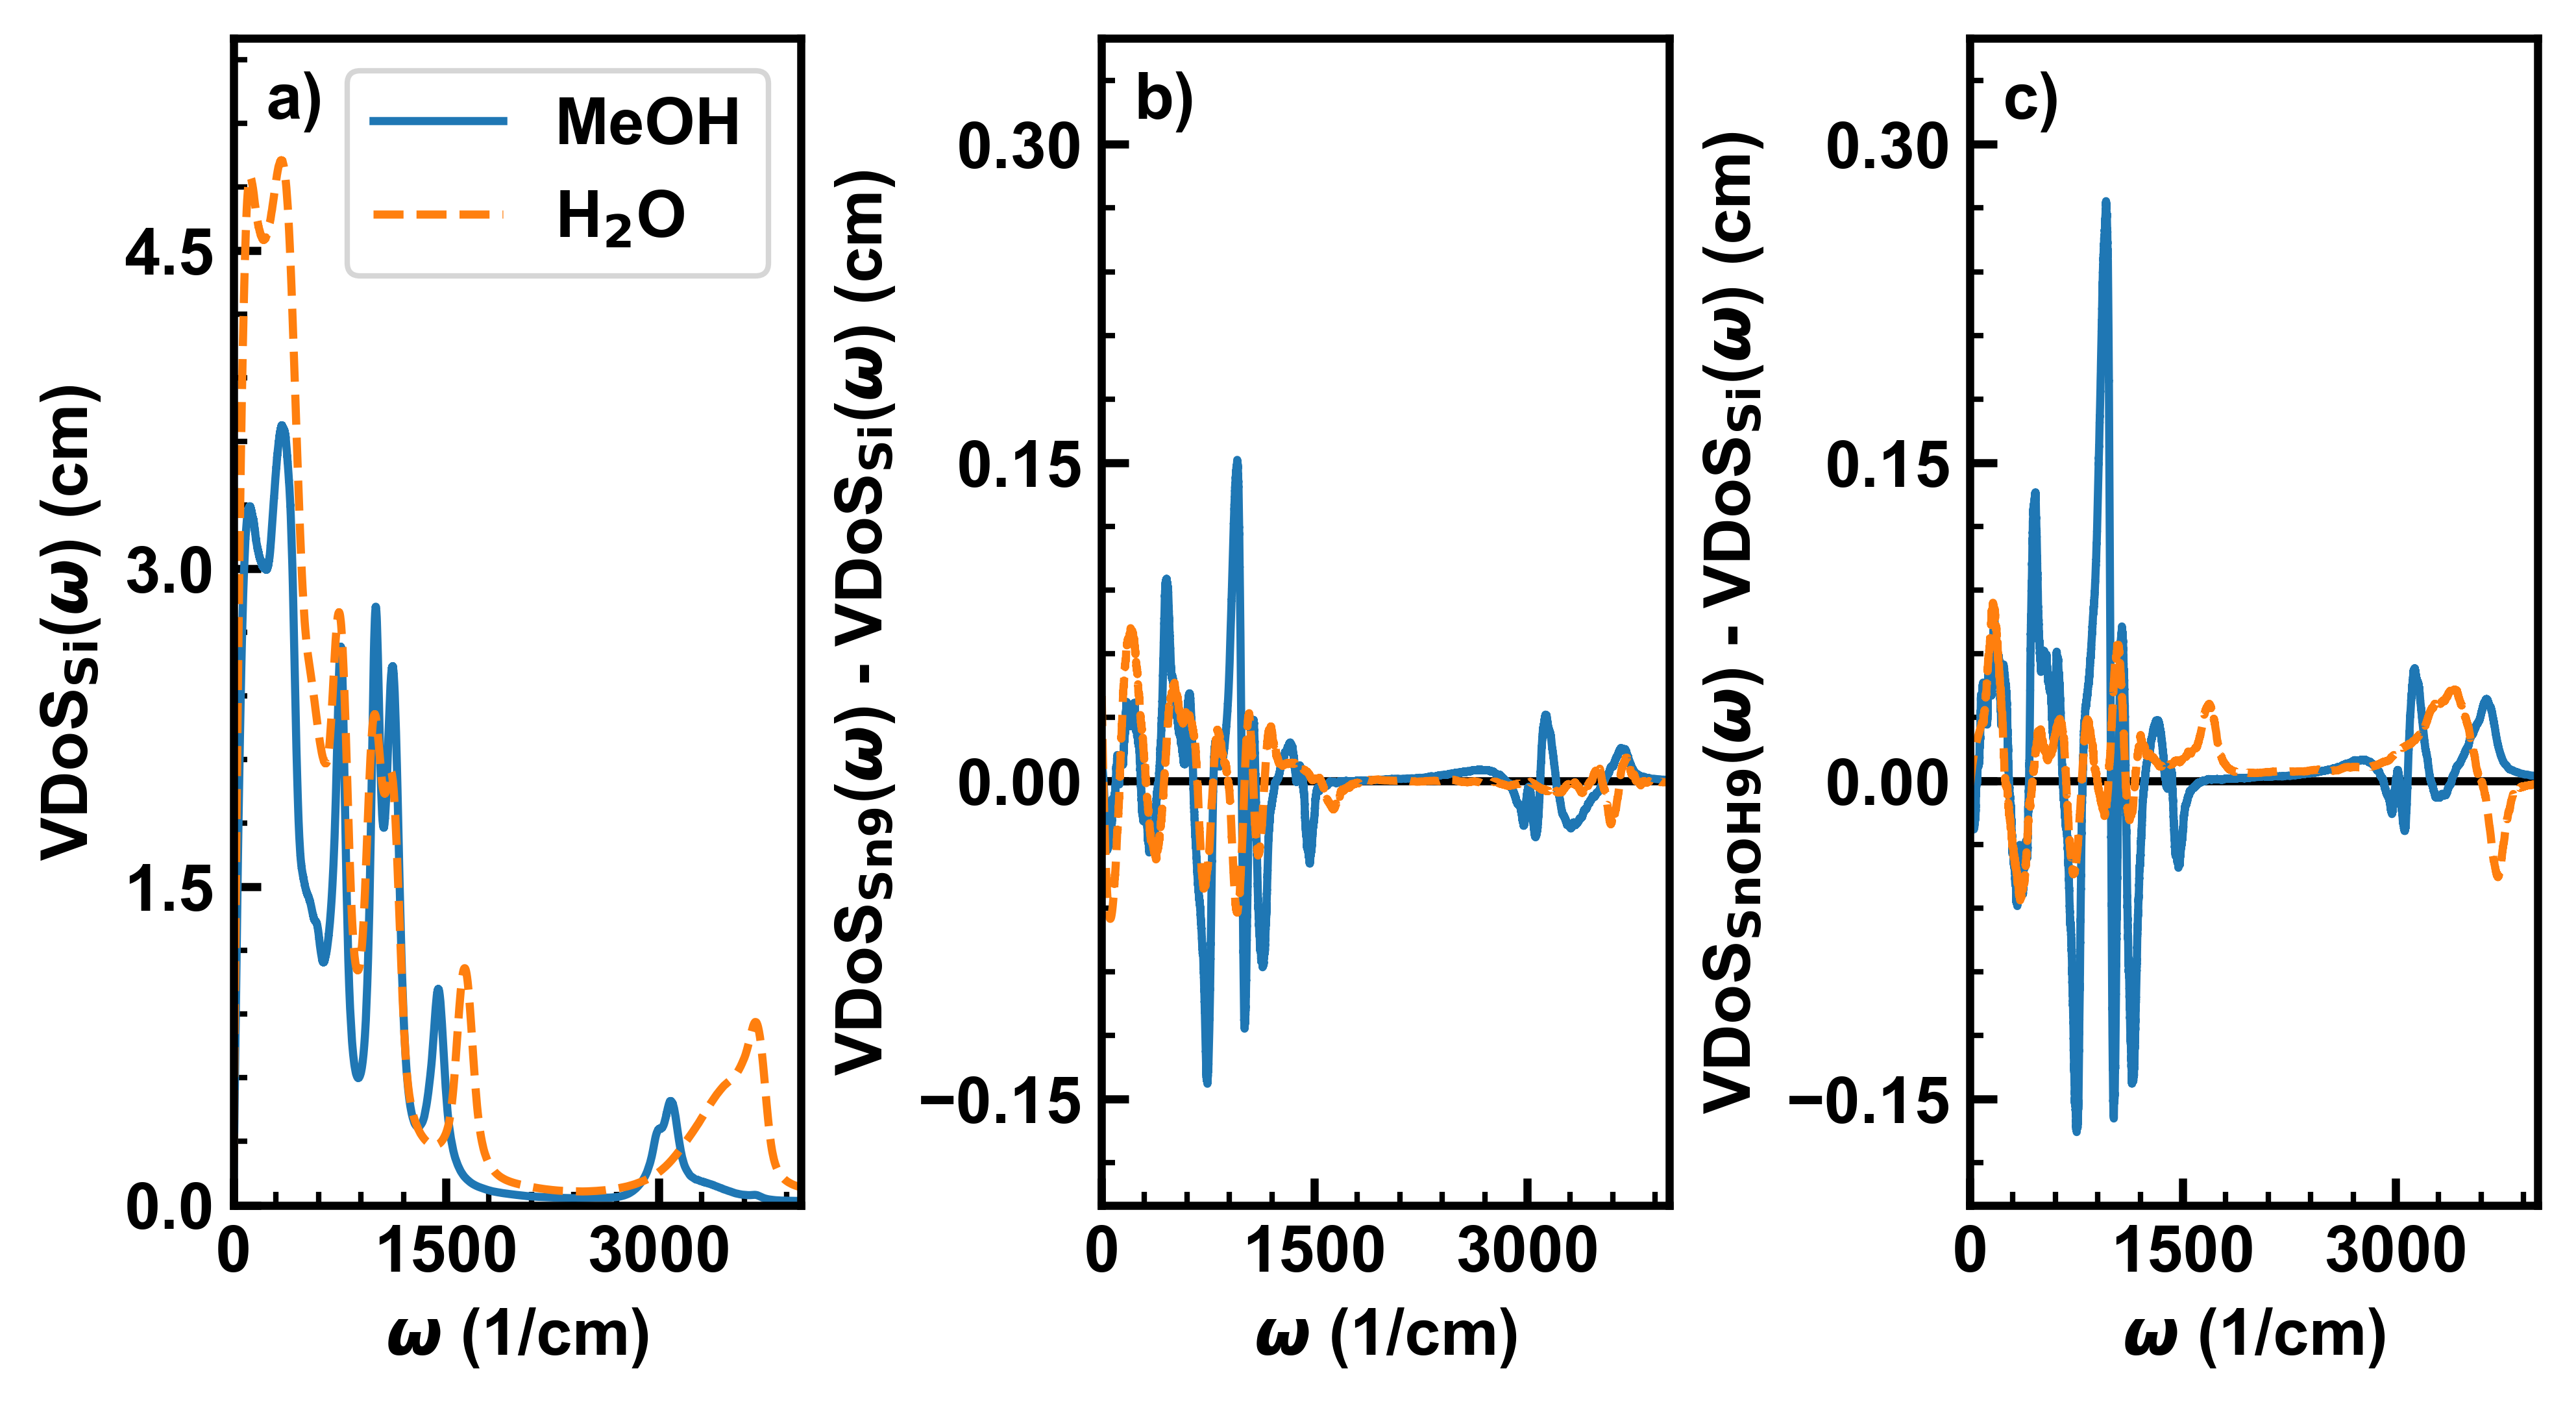

In [33]:

fig, axs = plt.subplot_mosaic([["a)", "b)", "c)"]], figsize=(6.5,3.5), sharey = False, dpi=600, layout='constrained')


def plot_2pt_simple(axs, filename, label, color, linestyle, filter_window=1000, difference=False, reference_df = None):
        df = pd.read_csv(filename)
        df['Sv_tot (cm)'] = savgol_filter(df['Sv_tot (cm)'], filter_window, 3)

        if difference and reference_df is not None:
                delta = df['Sv_tot (cm)'] - reference_df['Sv_tot (cm)']
                axs.plot(df['Freq (1/cm)'], delta, label = label, color = color, linestyle = linestyle) 
        else:
                axs.plot(df['Freq (1/cm)'], df['Sv_tot (cm)'], label = label, color = color, linestyle = linestyle)
        return df




meoh_ref = plot_2pt_simple(axs["a)"] , "../meoh-9/pureSi/373/vdos/all/sv.csv",   label = "MeOH", color = colors[0],  linestyle="solid")
wat_ref = plot_2pt_simple(axs["a)"] , "../wat-39/pureSi/373/vdos/all/sv.csv",  label = "H$_2$O", color = colors[1],  linestyle="dashed")

axs["b)"].hlines(y=0, xmin=0, xmax=4000, color="k")
axs["c)"].hlines(y=0, xmin=0, xmax=4000, color="k")

df = plot_2pt_simple(axs["b)"] , "../meoh-9/t9/373/vdos/all/sv.csv",   color = colors[0],  label = None, linestyle="solid", difference=True, reference_df = meoh_ref )
plot_2pt_simple(axs["b)"] , "../wat-39/t9/373/vdos/all/sv.csv",  color = colors[1], label = None,  linestyle="dashed",difference=True, reference_df = wat_ref )


plot_2pt_simple(axs["c)"] , "../meoh-9/st9/373/vdos/all/sv.csv", color = colors[0], label = None,  linestyle="solid", difference=True, reference_df = meoh_ref)
plot_2pt_simple(axs["c)"] , "../wat-39/st9/373/vdos/all/sv.csv", color = colors[1], label = None,  linestyle="dashed", difference=True, reference_df = wat_ref)


#fig.legend(loc = "outside upper center", ncols = 2, columnspacing = 0.6, handletextpad=0.2)

axs["a)"].legend()
axs["a)"].set_ylabel(r"VDoS$_\mathrm{Si}$($\omega$) (cm)")
axs["b)"].set_ylabel(r"VDoS$_\mathrm{Sn9}$($\omega$) - VDoS$_\mathrm{Si}$($\omega$) (cm)")
axs["c)"].set_ylabel(r"VDoS$_\mathrm{SnOH9}$($\omega$) - VDoS$_\mathrm{Si}$($\omega$) (cm)")


label_mosaic_subplot(axs)

axs["a)"].set_ylim(0.0, 5.5)
axs["b)"].set_ylim(-0.2, 0.35)
axs["c)"].set_ylim(-0.2, 0.35)
for key, ax in axs.items():
    
    ax.set_xlim(0, 4000)
    ax.set_xlabel(r"$\omega$ (1/cm)")
    set_ticks(ax, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 3)

pass


save_figure(fig, "water-methanol_vdos")


       Freq (1/cm)  Sv_tot (cm)
86341  3200.014394     0.161213
86342  3200.051456     0.161152
86343  3200.088519     0.161096
86344  3200.125581     0.160995
86345  3200.162644     0.160936
86346  3200.199706     0.160845
86347  3200.236769     0.160728
86348  3200.273831     0.160666
86349  3200.310894     0.160608
86350  3200.347956     0.160574
86351  3200.385019     0.160543
86352  3200.422081     0.160454
86353  3200.459144     0.160394
86354  3200.496206     0.160300
86355  3200.533269     0.160229
86356  3200.570331     0.160164
86357  3200.607394     0.160103
86358  3200.644456     0.160037
86359  3200.681519     0.159972
86360  3200.718581     0.159883
86361  3200.755644     0.159821
86362  3200.792706     0.159728
86363  3200.829769     0.159686
86364  3200.866831     0.159642
86365  3200.903894     0.159588
86366  3200.940956     0.159564
86367  3200.978019     0.159504


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


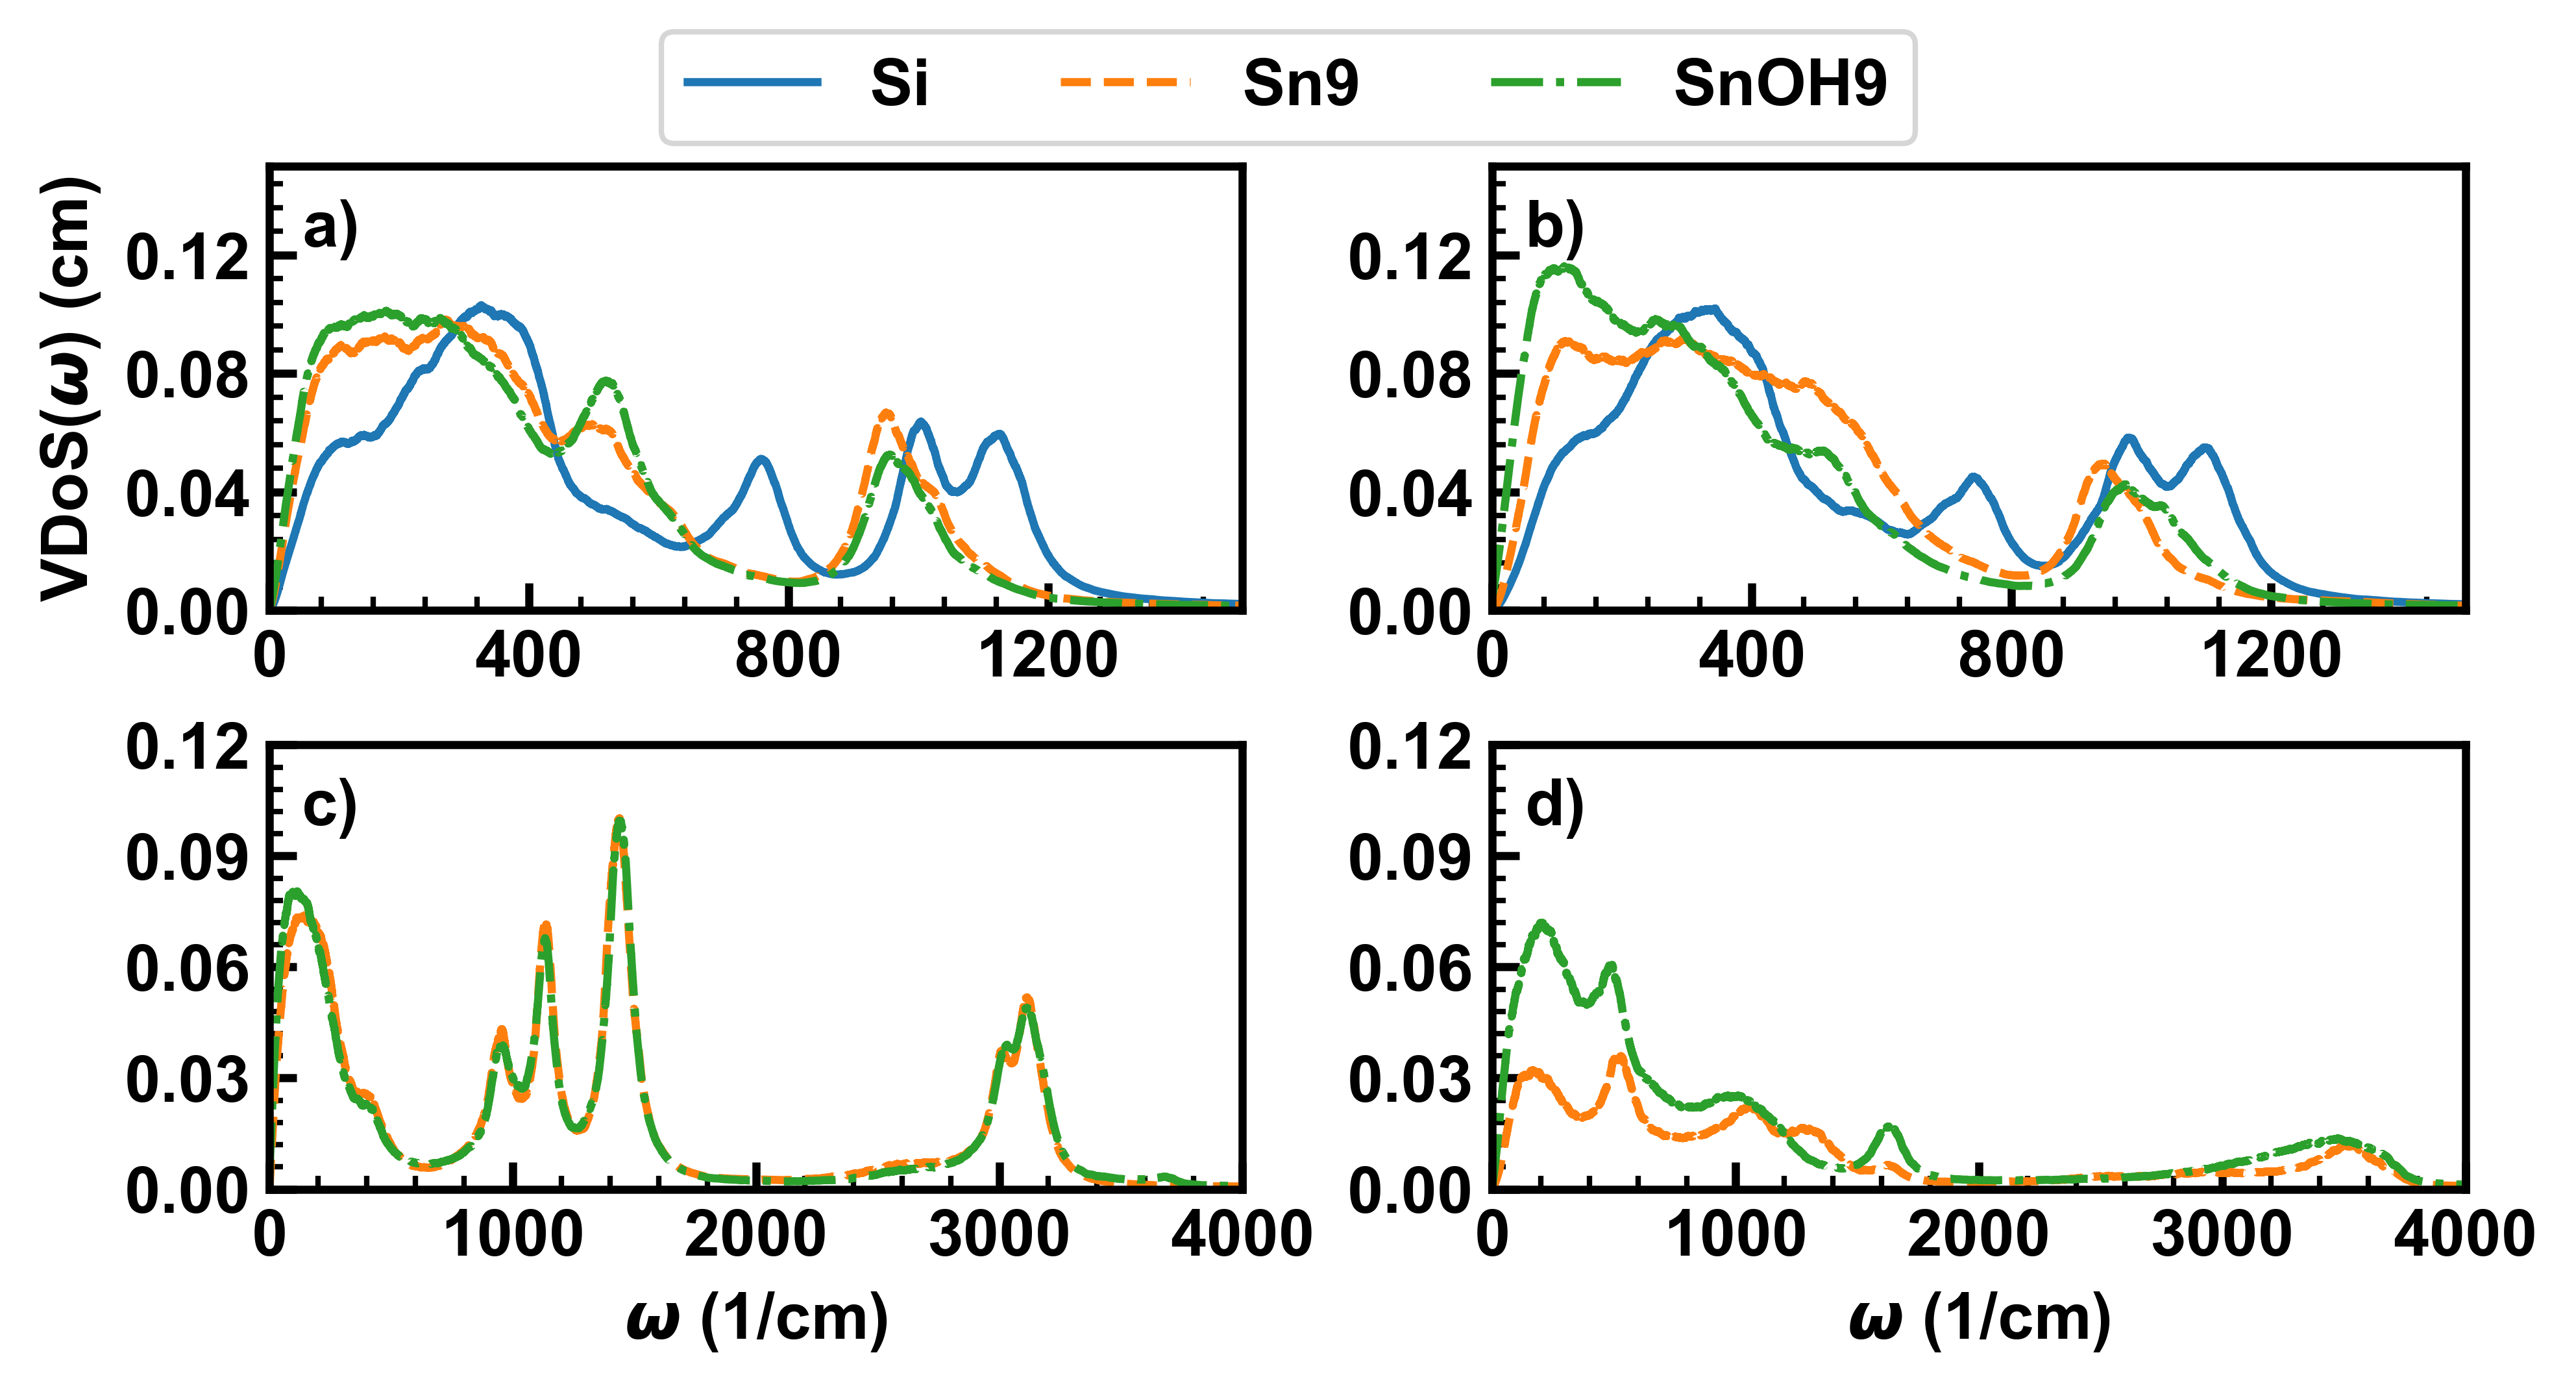

In [7]:
fig, axs = plt.subplot_mosaic([["a)", "b)"],["c)", "d)"]], figsize=(6.5,3.5), sharey = False, dpi=600, layout='constrained')


df = plot_2pt(axs["a)"] , "../meoh-9/pureSi/373/vdos/si-t9/sv.csv", colors, decomposed=False, label = "Si", color = colors[0], normalize = 1, filter = True, linestyle="solid")
plot_2pt(axs["a)"] , "../meoh-9/t9/373/vdos/sn-tsite/sv.csv", colors, decomposed=False, label = "Sn9", color = colors[1], normalize = 1, filter = True, linestyle="dashed")
plot_2pt(axs["a)"] , "../meoh-9/st9/373/vdos/sn-tsite/sv.csv", colors, decomposed=False, label = "SnOH9", color = colors[2], normalize = 1, filter = True, linestyle = "dashdot")

plot_2pt(axs["b)"] , "../wat-39/pureSi/373/vdos/si-t9/sv.csv", colors, decomposed=False, label = None, color = colors[0], normalize = 1, filter = True, linestyle="solid")
plot_2pt(axs["b)"] , "../wat-39/t9/373/vdos/sn-tsite/sv.csv", colors, decomposed=False, label = None, color = colors[1], normalize = 1, filter = True, linestyle="dashed")
plot_2pt(axs["b)"] , "../wat-39/st9/373/vdos/sn-tsite/sv.csv", colors, decomposed=False, label = None, color = colors[2], normalize = 1, filter = True, linestyle = "dashdot")




plot_2pt(axs["c)"] , "../meoh-9/t9/373/vdos/ads/sv.csv", colors, decomposed=False, label = None, color = colors[1], normalize = 1, filter = True, linestyle="dashed")
plot_2pt(axs["c)"] , "../meoh-9/st9/373/vdos/ads/sv.csv", colors, decomposed=False, label = None, color = colors[2], normalize = 1, filter = True, linestyle = "dashdot")

plot_2pt(axs["d)"] , "../wat-39/t9/373/vdos/ads/sv.csv", colors, decomposed=False, label = None, color = colors[1], normalize = 1, filter = True, linestyle="dashed")
plot_2pt(axs["d)"] , "../wat-39/st9/373/vdos/ads/sv.csv", colors, decomposed=False, label = None, color = colors[2], normalize = 1, filter = True, linestyle = "dashdot")



for key, ax in axs.items():
    

    set_ticks(ax, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 4, xticks = 4)

axs["a)"].set_xlim(0, 1500)
axs["b)"].set_xlim(0, 1500)
axs["c)"].set_xlim(0, 4000)
axs["d)"].set_xlim(0, 4000)

axs['a)'].set_ylim(0.0, 0.15)
axs['b)'].set_ylim(0.0, 0.15)

axs['c)'].set_ylim(0.0, 0.12)
axs['d)'].set_ylim(0.0, 0.12)

axs["a)"].set_ylabel(r"VDoS($\omega$) (cm)")

axs["c)"].set_xlabel(r"$\omega$ (1/cm)")
axs["d)"].set_xlabel(r"$\omega$ (1/cm)")
label_mosaic_subplot(axs)

fig.legend(loc = "outside upper center", ncols = 3, )#columnspacing = 0.6, handletextpad=0.2)

save_figure(fig, "tsite-adsorbate")




In [31]:
print(df[["Freq (1/cm)", "Sv_tot (cm)"]][df["Freq (1/cm)"].between(1100, 1130)])

       Freq (1/cm)  Sv_tot (cm)
29680  1100.015372     0.054697
29681  1100.052434     0.054706
29682  1100.089497     0.054746
29683  1100.126559     0.054669
29684  1100.163622     0.054684
...            ...          ...
30485  1129.850694     0.058597
30486  1129.887757     0.058588
30487  1129.924819     0.058545
30488  1129.961882     0.058539
30489  1129.998944     0.058564

[810 rows x 2 columns]
